<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
LightGBM for Regression 
</p>

In [1]:
# Libraries for data manipulation and visualization
import os
import pickle
import numpy as np                               # For numerical operations
import pandas as pd                              # For data manipulation
import matplotlib.pyplot as plt                  # For plotting
import seaborn as sns                            # For advanced data visualization

# Libraries for model building and evaluation
from sklearn.model_selection import PredefinedSplit, learning_curve
from scipy.stats import linregress

from sklearn.metrics import (                     # For model evaluation metrics
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)

# LightGBM library
import lightgbm as lgb                            # For LightGBM Regressor

# Bayesian optimization imports
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

import warnings
# Suppress specific FutureWarning about 'force_all_finite'
warnings.filterwarnings("ignore", category=FutureWarning, message=".*'force_all_finite'.*")
# Suppress skopt UserWarnings about repeated evaluation of the same hyperparameter set
warnings.filterwarnings("ignore", category=UserWarning, module='skopt')
# Suppress FutureWarning about sklearn tags in LGBMRegressor (compatibility issue, harmless)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils._tags")
# Suppress UserWarning: X does not have valid feature names
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Dataset: Load Splits 
</p>

In [2]:
# Path to the standardized database directory
base_path = '../../Comprehensive ML - Files & Plots etc'

# Load train and test splits
df_train = pd.read_csv(f"{base_path}/train.csv")
df_test = pd.read_csv(f"{base_path}/test.csv")

feature_names = [
    'distance', 'frequency', 'c_walls', 'w_walls', 'co2', 'humidity', 
    'pm25', 'pressure', 'temperature', 'snr'
]

X_train = df_train[feature_names].values
y_train = df_train['PL'].values
X_test = df_test[feature_names].values
y_test = df_test['PL'].values

# (Should we need them for plotting)
time_train = df_train['time'].values
time_test = df_test['time'].values

# Load 5-fold assignments
fold_assignments = np.load(f"{base_path}/train_folds.npy")

print(f"\nTraining samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
unique, counts = np.unique(fold_assignments, return_counts=True)
print(dict(zip(unique, counts)))
print('\nDataset loaded successfully!\n')


Training samples: 1663627, Test samples: 415907
{0: 332726, 1: 332726, 2: 332725, 3: 332725, 4: 332725}

Dataset loaded successfully!



<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Define Bayesian Search Space and Model Helper
</p>

In [3]:
# Our param space for Bayesian optimization
search_spaces = {
    'num_leaves': Integer(10, 100),  # Number of leaves in each tree (widened for flexibility)
    'max_depth': Integer(1, 5),      # Maximum tree depth
    'learning_rate': Real(0.03, 0.08, prior='log-uniform'),  # Learning rate
    'n_estimators': Integer(100, 300),  # Number of boosting iterations
    'min_child_samples': Integer(100, 1000),  # Minimum samples per leaf (similar to min_child_weight, but sample count)
    'min_child_weight': Real(5, 30, prior='log-uniform'),  # Minimum sum of instance weight (hessian)
    'subsample': Real(0.6, 0.8),     # Subsample ratio of training instances
    'colsample_bytree': Real(0.6, 0.8),  # Subsample ratio of columns
    'reg_alpha': Real(0, 10),         # L1 regularization
    'reg_lambda': Real(0, 10)         # L2 regularization
}

def create_lgb_model():
    return lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        random_state=50, 
        n_jobs=-1,
        verbosity=-1  # Suppress LightGBM output
    )

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Bayesian SearchCV with Custom Folds & Analysis Per-Depth Results 
</p>

In [4]:
# ---- Setup for multi-metric scoring ----
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

# ---- Create PredefinedSplit ( with ready fold_assignments) ----
ps = PredefinedSplit(fold_assignments)

# ---- Bayesian optimization, scoring on both RMSE and R² ----
bayes_cv = BayesSearchCV(
    estimator=create_lgb_model(),  # function for LGBM config
    search_spaces=search_spaces,
    n_iter=15,  # or as desired
    scoring=scoring,
    refit='neg_root_mean_squared_error',  # selects best by RMSE
    n_jobs=-1,
    cv=ps,
    random_state=42,
    verbose=2,
    n_points=1,  # Default = 1; can be adjusted for parallel if hardware allows
    optimizer_kwargs={'n_initial_points': 10, 'acq_func': 'gp_hedge'}  # More initial randoms; robust acquisition
)

print(f"Starting Bayesian optimization with {bayes_cv.n_iter} iterations "
      f"and {ps.get_n_splits()}-fold cross-validation per candidate...")

# ---- Fit Bayesian optimizer on training data ----
bayes_cv.fit(X_train, y_train) 

print("Bayesian optimization complete. Extracting results...")

# ---- Pull all tried configs/results into a dataframe ----
bayes_results = pd.DataFrame(bayes_cv.cv_results_)

# ---- For each max_depth, track best results for plotting ----
cv_summary_per_depth = []
for max_depth in range(1, 6):
    mask = bayes_results['param_max_depth'] == max_depth
    df_depth = bayes_results[mask]
    if not df_depth.empty:
        # Find best (highest) mean_test_neg_root_mean_squared_error (less negative = better)
        idx = df_depth['mean_test_neg_root_mean_squared_error'].idxmax()
        best_row = df_depth.loc[idx]
        best_rmse = -best_row['mean_test_neg_root_mean_squared_error']
        std_rmse = best_row['std_test_neg_root_mean_squared_error']
        best_cv_r2 = best_row['mean_test_r2']
        std_cv_r2 = best_row['std_test_r2']
        best_params = {k.split('param_')[1]: best_row[k] for k in bayes_results.columns if k.startswith('param_')}
        print(f"Best Params for max_depth={max_depth}: {best_params}")
        print(f"Best CV RMSE for max_depth={max_depth}: {best_rmse:.4f}")
        print(f"STD of CV RMSE for max_depth={max_depth}: {std_rmse:.4f}")
        print(f"Best CV R² for max_depth={max_depth}: {best_cv_r2:.4f}")
        print(f"STD of CV R² for max_depth={max_depth}: {std_cv_r2:.4f}")
        cv_summary_per_depth.append({
            'max_depth': max_depth,
            'best_cv_rmse': best_rmse,
            'std_cv_rmse': std_rmse,
            'best_cv_r2': best_cv_r2,
            'std_cv_r2': std_cv_r2,
            'best_params': best_params
        })

cv_df = pd.DataFrame(cv_summary_per_depth)

Starting Bayesian optimization with 15 iterations and 5-fold cross-validation per candidate...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bytree=0.6820207917706628, learning_rate=0.061250504047638446, max_depth=5, min_child_samples=384, min_child_weight=16.612938916177544, n_estimators=183, num_leaves=42, reg_alpha=7.3950423419042055, reg_lambda=3.044633110365062, subsample=0.7295583176693756; total time=25.5min
[CV] END colsample_bytree=0.6820207917706628, learning_rate=0.061250504047638446, max_depth=5, min_child_samples=384, min_child_weight=16.612938916177544, n_estimators=183, num_leaves=42, reg_alpha=7.3950423419042055, reg_lambda=3.044633110365062, subsample=0.7295583176693756; total time=25.8min
[CV] END colsample_bytree=0.6820207917706628, learning_rate=0.061250504047638446, max_depth=5, min_child_samples=384, min_child_weight=16.612938916177544, n_estimators=183, num_leaves=42, reg_alpha=7.3950423419042055, reg_lambda=3.044633110365062, subs

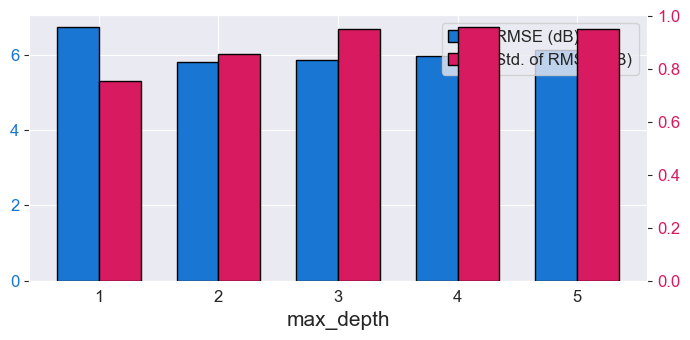

In [5]:
# ---- FONT SIZE METRICS ----
tick_fontsize = 12         # Tick label size
axis_labelsize = 15        # Axis label size
legend_fontsize = 12       # Legend font size

# ---- GLOBAL FONT FAMILY: Times New Roman ----
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

sns.set_style("darkgrid")

x = np.arange(len(cv_df['max_depth']))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

# Blue bars: Best CV RMSE (left y-axis)
bars1 = ax1.bar(
    x - bar_width/2, 
    cv_df['best_cv_rmse'], 
    bar_width, 
    color='#1976d2',
    label='RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
#ax1.set_ylabel('RMSE (dB)', color='#1976d2', fontsize=axis_labelsize)
ax1.set_xlabel('max_depth', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(cv_df['max_depth'], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelcolor='#1976d2', labelsize=tick_fontsize)
ax1.grid(True, axis='y')

# Magenta bars: STD of CV RMSE (right y-axis), offset to right
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2, 
    cv_df['std_cv_rmse'], 
    bar_width, 
    color='#d81b60',
    label='Std. of RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
#ax2.set_ylabel('Std. of RMSE (dB)', color='#d81b60', fontsize=axis_labelsize)
ax2.tick_params(axis='y', labelcolor='#d81b60', labelsize=tick_fontsize)
ax2.grid(False)

# Single legend
handles = [
    plt.Rectangle((0,0),1,1,color='#1976d2',ec='black',label='RMSE (dB)'),
    plt.Rectangle((0,0),1,1,color='#d81b60',ec='black',label='Std. of RMSE (dB)')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
plt.savefig('../../Comprehensive ML - Files & Plots etc/LGBM_bestRMSE_&_STD_perDepth.png', dpi=2000, bbox_inches='tight')
plt.show()

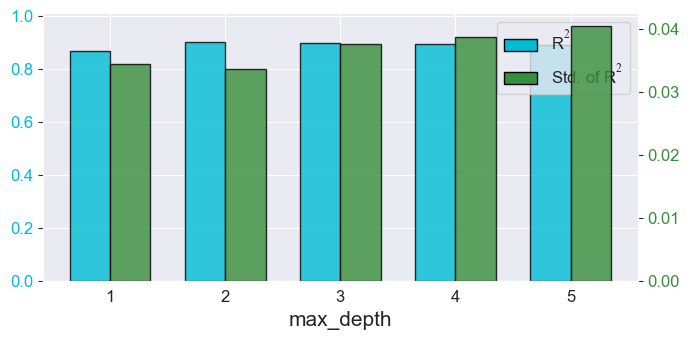

In [6]:
# ---- FONT SIZE METRICS ----
tick_fontsize = 12         # Tick label size
axis_labelsize = 15        # Axis label size
legend_fontsize = 12       # Legend font size

# ---- GLOBAL FONT FAMILY: Times New Roman ----
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

sns.set_style("darkgrid")

x = np.arange(len(cv_df['max_depth']))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

# --- Cyan bars: Best CV R² (left y-axis) ---
bars1 = ax1.bar(
    x - bar_width/2, 
    cv_df['best_cv_r2'], 
    bar_width, 
    color='#00bcd4',                # Cyan
    edgecolor='black',
    linewidth=1,
    alpha=0.8,
    label='R$^2$'
)
ax1.set_xlabel('max_depth', fontsize=axis_labelsize)
#ax1.set_ylabel('Best CV R$^2$', color='#00bcd4', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(cv_df['max_depth'], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelcolor='#00bcd4', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)
ax1.set_ylim(0, 1.01)
ax1.grid(True, axis='y')

# --- Green bars: STD of CV R² (right y-axis) ---
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2, 
    cv_df['std_cv_r2'], 
    bar_width, 
    color='#388e3c',                # Green
    edgecolor='black',
    linewidth=1,
    alpha=0.8,
    label='Std. of R$^2$'
)
#ax2.set_ylabel('Std. of CV R$^2$', color='#388e3c', fontsize=axis_labelsize)
ax2.tick_params(axis='y', labelcolor='#388e3c', labelsize=tick_fontsize)
ax2.grid(False)

# --- Combined Legend (top right, inside) ---
handles = [
    plt.Rectangle((0,0),1,1,color='#00bcd4',ec='black',label='R$^2$'),
    plt.Rectangle((0,0),1,1,color='#388e3c',ec='black',label='Std. of R$^2$')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
#plt.savefig('../../Comprehensive ML - Files & Plots etc/LGBM_bestR2_STD_perDepth.png', dpi=2000, bbox_inches='tight')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Train on All Training Data and Test Evaluation 
</p>

In [7]:
# Use built-in best_estimator_ (already refitted on full train data) and best_params_
best_model = bayes_cv.best_estimator_
best_params = bayes_cv.best_params_
print("Best Parameters Found:", best_params)

print("\nUsing best model from BayesSearchCV (already trained on all data)...")

# Convert arrays to DataFrames with feature names
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_median_ae = median_absolute_error(y_test, y_test_pred)

results = pd.DataFrame({
    'Metric': [
        'Training Loss (MSE)', 'Test Loss (MSE)', 'Test RMSE',
        'R² Score (Train)', 'R² Score (Test)', 'Test MAPE (%)', 'Test Median AE'
    ],
    'Value': [
        train_mse, test_mse, test_rmse, train_r2, test_r2,
        test_mape * 100, test_median_ae
    ]
})

print("\nModel Evaluation Metrics:")
display(results)

Best Parameters Found: OrderedDict({'colsample_bytree': 0.7674776711106569, 'learning_rate': 0.07134868013899764, 'max_depth': 2, 'min_child_samples': 956, 'min_child_weight': 23.51755791729486, 'n_estimators': 112, 'num_leaves': 22, 'reg_alpha': 3.535873976284181, 'reg_lambda': 6.357291018791703, 'subsample': 0.7906960300379587})

Using best model from BayesSearchCV (already trained on all data)...

Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),29.516083
1,Test Loss (MSE),25.617411
2,Test RMSE,5.061365
3,R² Score (Train),0.916628
4,R² Score (Test),0.927738
5,Test MAPE (%),4.485195
6,Test Median AE,3.164864


In [8]:
# Ensure the directory exists
os.makedirs('Models', exist_ok=True)

# Save the trained LightGBM model
with open('../Models/lgbm_final_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Trained LightGBM model saved to Models/lgbm_final_model.pkl")

Trained LightGBM model saved to Models/lgbm_final_model.pkl


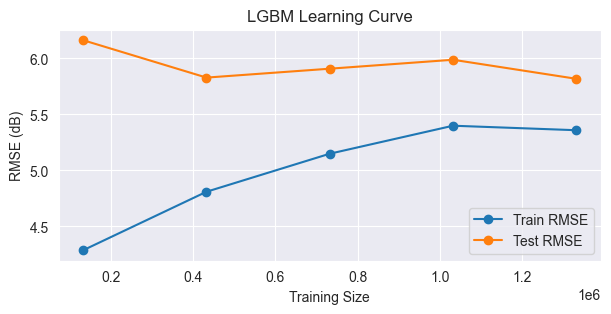

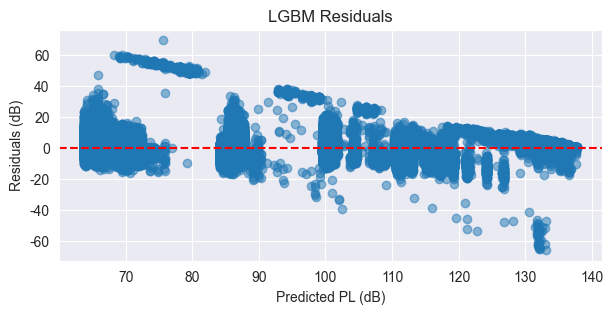

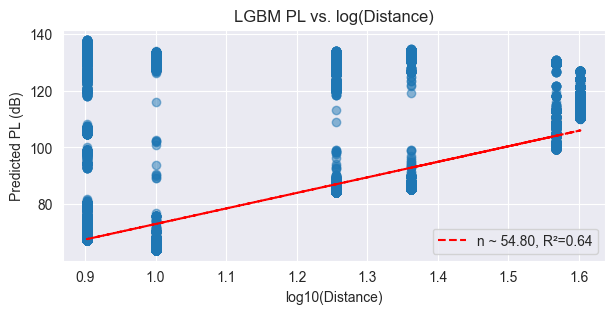

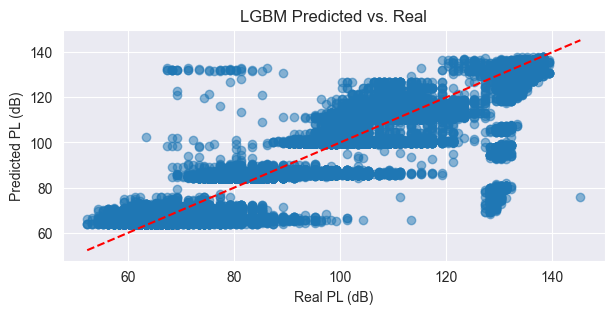

In [9]:
# Use best_model for plots
lgb_model = best_model

figsize = (7, 3)
path = '../../Comprehensive ML - Files & Plots etc/'

# 1. Learning Curve
train_sizes, train_scores, test_scores = learning_curve(lgb_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), scoring='neg_root_mean_squared_error')
train_rmse = -train_scores.mean(1)
test_rmse = -test_scores.mean(1)
plt.figure(figsize=figsize)
plt.plot(train_sizes, train_rmse, 'o-', label='Train RMSE')
plt.plot(train_sizes, test_rmse, 'o-', label='Test RMSE')
plt.xlabel('Training Size')
plt.ylabel('RMSE (dB)')
plt.title('LGBM Learning Curve')
plt.legend()
#plt.savefig(f'{path}LGBM_learning_curve.png', dpi=300)
plt.show()

# 2. Residuals
y_test_pred = lgb_model.predict(X_test)
residuals = y_test - y_test_pred
plt.figure(figsize=figsize)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted PL (dB)')
plt.ylabel('Residuals (dB)')
plt.title('LGBM Residuals')
#plt.savefig(f'{path}LGBM_residuals.png', dpi=300)
plt.show()

# 3. Physics Consistency (PL vs. log(distance))
dist = df_test['distance'].values
log_dist = np.log10(dist + 1e-6)
slope, intercept, r_value, _, _ = linregress(log_dist, y_test_pred)
plt.figure(figsize=figsize)
plt.scatter(log_dist, y_test_pred, alpha=0.5)
plt.plot(log_dist, intercept + slope * log_dist, 'r--', label=f'n ~ {slope:.2f}, R²={r_value**2:.2f}')
plt.xlabel('log10(Distance)')
plt.ylabel('Predicted PL (dB)')
plt.title('LGBM PL vs. log(Distance)')
plt.legend()
#plt.savefig(f'{path}LGBM_physics_consistency.png', dpi=300)
plt.show()

# 4. Predicted vs. Real
plt.figure(figsize=figsize)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real PL (dB)')
plt.ylabel('Predicted PL (dB)')
plt.title('LGBM Predicted vs. Real')
#plt.savefig(f'{path}LGBM_pred_vs_real.png', dpi=300)
plt.show()